In [2]:
#A code to fit continuum, pseudo-continuum, and/or baselines to image cubes from the JWST nirspec ifu
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from spectral_cube import SpectralCube

check2 4.19
0 4.19 737
check1 4.32
1 4.32 73
check1 4.37
2 4.37 28
check1 4.4
3 4.4 17
check1 4.62
4 4.62 123
check1 4.72
5 4.72 55
check1 4.87
6 4.87 84
check3 4.939
7 4.939 184


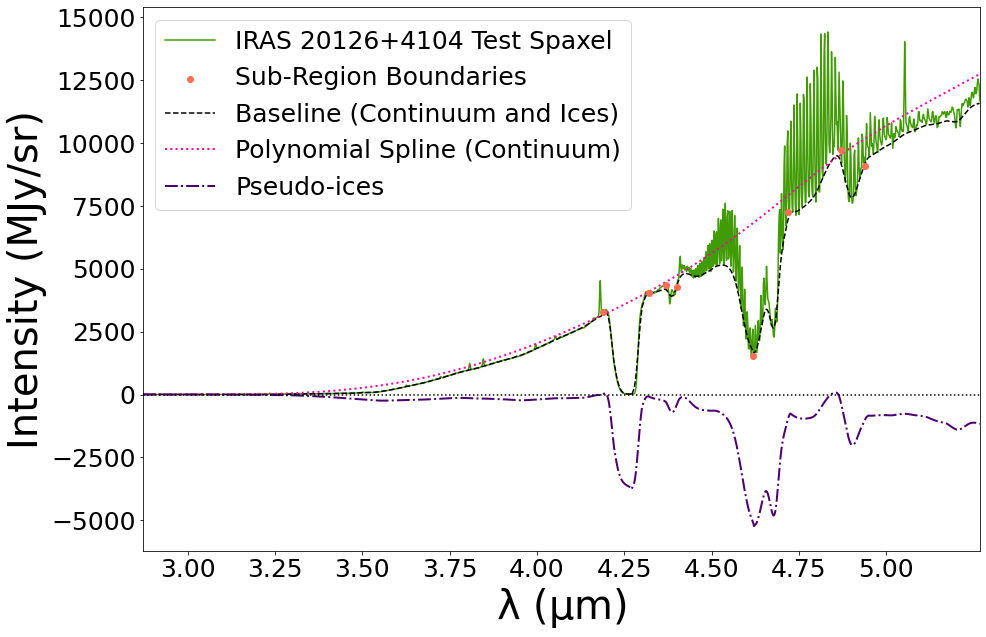

In [21]:
#testing an initial filter + interpolation for baselines
from pybaselines import Baseline
from scipy.signal import medfilt, savgol_filter #try different filters for a second round of smoothing

#prepare your PATHs to data and read in the data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_s3d.fits']
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104']
protostar_ind = 4 #CHANGE: to change protostars

#read in some data
hdul = fits.open(cube_file_list[protostar_ind])
cube = fits.getdata(cube_file_list[protostar_ind])

#now that we have chosen a protostar...
#make a figure to plot various locations on an image
if protostar_ind == 3: #because some protostars have long names
    fig, ax = plt.subplots(figsize=(17,10)) #setup fig, axes
else:
    fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes


# define the wavelength grid (microns) from the header
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for spectral axis, could also be used to get data (but I try to minimize dependencies)
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #remember to cutoff the edges which may have noise
# wave_cut = 3
# wave_mask = wave > wave_cut #if you'd like to mask to select a section of the spectrum
# wave = wave[wave_mask]

# extracting spectra around a centrally located spaxel, feel free to adjust the variable "central_sources"
central_sources = [(46.57459417809592, 45.12978229),  (46.73250708463416, 43.13112798), (46.47088442936513, 46.6279981), (41.71119797770727, 43.61467905), (43.38667807448542, 43.15705917)]
flux_1pix = cube[:, int(central_sources[protostar_ind][0]), int(central_sources[protostar_ind][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
# flux_1pix = flux_1pix[wave_mask] #if masking
ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Test Spaxel') #plot observation here!

#prepare and apply low-pass aka top hat filter, which will remove all peaks (low-pass = low frequency spectral features pass, while high frequency is filtered out)
baseline_fitter = Baseline(wave, check_finite=False) #the general setup in pybaselines is first you need your x-axis values, your wavelengths in this case
bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0] #then you fit the y-data; feel free to adjust half_window

#formulating regimes to cutoff the spectrum and apply different smoothing factors
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939]) #can adjust these as you like
# vline_list = [ax.axvline(i, color='k', linestyle=':') for i in [4.19, 4.33, 4.36, 4.42, 4.58, 4.7, 4.95]] #to plot as vertical lines
cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]] #sectioning the spectrum using our boundaries
ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #plot the spectral region boundaries; other oranges work

#useful parameters you can change in one spot
smooth_list = [1, 1, 10, 1, 5, 3, 10, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 1, 1] #regularization parameter (relative levels of noise and signal)
param_secondtolast = [2, 7] #the second to last region I couldn't figure out how to reduce the loop for some reason, so I set it individually

#loop over our boundaries, the breakpoints, in the spectrum
baseline_list = []
for cutoff_ind in range(len(wave_cutoff_list)):
    #if between two values and not at the edge cases
    if cutoff_ind != 0 and cutoff_ind != len(wave_cutoff_list)-1:
        print('check1', wave_cutoff_list[cutoff_ind])
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
    #if edge case at start
    elif cutoff_ind == 0:
        print('check2', wave_cutoff_list[cutoff_ind])
        cutoff_mask = wave < wave_cutoff_list[cutoff_ind] #define mask up to first marker
    #if edge case at end, need to do this twice! (as I have it set up here at least)
    elif cutoff_ind == len(wave_cutoff_list)-1:
        print('check3', wave_cutoff_list[cutoff_ind])
        #first, do the case I'd otherwise miss here 
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values

        #fit baseline for second to last region
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=param_secondtolast[0],alpha=param_secondtolast[1])[0]
        baseline_list = np.concatenate((baseline_list, baseline))

        #then we cutoff at end and fit that
        cutoff_mask = wave > wave_cutoff_list[cutoff_ind] #define mask past last marker
    print(cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

    #compute baseline
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to a single list

#an alternative approach partially made using the you.com chatbot AI - looks similar but would need editing to function for entire cube
# wave_cutoff_inds = np.array([np.abs(wave - i).argmin() for i in wave_cutoff_list])
# wave_sectioned = np.split(wave, wave_cutoff_inds)
# flux_sectioned =  np.split(flux, wave_cutoff_inds)
# baseline_list = np.array([baseline_fitter.jbcd(np.split(bkg_top, wave_cutoff_inds)[i], half_window=smooth_list[i],alpha=alpha_list[i])[0] for i in range(len(wave_cutoff_inds))]).flatten()

# baseline_list = np.zeros_like(wave)
# for i in range(len(wave_cutoff_list) - 1):
#     idx = (wave >= wave_cutoff_list[i]) & (wave < wave_cutoff_list[i+1])
#     mask = np.where(idx)[0]
#     baseline_fitter = Baseline(wave[mask], check_finite=False)
#     baseline = baseline_fitter.jbcd(bkg_top[mask], half_window=smooth_list[i], alpha=alpha_list[i])[0]
#     baseline_list[mask] = baseline

''' 
Not smooth enough? around the boundaries there are spikes...now we need a second round...
Filter around our control or anchor points
There are a variety of filters you can use from SciPy, such as
1) savgol_filter = a Gaussian-like shape which helps for generic smoothing 
2) medfilt = a filter that checks your intensity values at neighboring points and tries to find a value in between via an average or statistic (median in this case)
You should feel free to try other filters or smoothing methods
'''
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying a multiple of that
for cutoff_ind in range(len(wave_cutoff_list)): #loop through the boundary points
    idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res to set wavelength range
    idx_mask = np.where(idx)[0] #making mask from indices
    # baseline_list[idx_mask] = medfilt(baseline_list[idx_mask], kernel_size=11) #if you'd like to apply a different filter
    baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

#plotting the baseline
ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
# ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #if you'd like to look at the line emission

#creating a pseudo-continuum based on the baseline to determine ices and a transmission curve
#so let's fit a baseline to a baseline!
#if using asls, for parameters use lam=5e5, p=0.999
baseline_fitter = Baseline(wave, check_finite=False)
ice_list = baseline_fitter.asls(baseline_list, lam=5e5, p=0.999)[0] #this is like a weighted polynomial; you can change any parameters or even replace the method as you like
ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices') #not a real model!

#formatting plot
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ' Central Spaxel', fontsize=30) #title
# ax.set_yscale('log') #if you would like to set a log scale
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=25)
ax.set_xticks(np.arange(3, 5.25, 0.25))
ax.set_xlim(np.min(wave), np.max(wave)) #setting wavelength domain to work in
# ax.set_ylim(500,) #setting intensity ranges
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=25)

#if you'd like to save as a pdf, png, etc use this
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

' after creating file, add to the header\n\nfile: 1D spectrum by Adam Rubinstein\nprotostar: IRAS 16253\nstat method: sum\naperture shape: square\naperture side length or diameter: 1 arcsec\nadditional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. \nadditional notes: centered using alma coordinates\n\n'

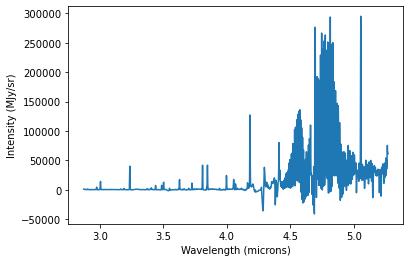

In [25]:
#if you'd like to read in data from an output...

# Read in a 3-D IFU datacube of interest, and header
#first, finding and noting the path
protostar_folders = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
cube_file_list = [glob('Baseline_Subtracted/' + i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

# now to actually read in the data 
protostar_ind = 4 #IMPORTANT: remember to pick your protostar
cube_file = cube_file_list[protostar_ind]
hdul = fits.open(cube_file)
cube = fits.getdata(cube_file)
nirspec_cube = SpectralCube.read(hdul[0]) #accessing the cube for data  
header_cube = hdul[0].header

# define the wavelength grid (microns) from the header
# offset_list = [1.95e-3, 2e-3, 9.75e-4, 1.05e-3, 1.825e-3] #done by hand
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental round 2 with initial changes to baselines
wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1e6 #to convert from meters to microns
wave = wave_factor * wave_units * nirspec_cube.spectral_axis.value + wave_offset #I add an offset to better fit line emission

# make a 1d spectrum over the central region, taking an average or statistic (sum or median) to attempt to account for random issues (noise, cosmic rays, etc)
central_sources = [(int(46.57459417809592), int(45.12978229)),  (int(46.73250708463416), int(43.13112798)), (int(46.47088442936513), int(46.6279981)), \
                        (int(41.71119797770727), int(43.61467905)), (int(43.38667807448542), int(43.15705917))]
arc_to_pix = 1 * 2.7777778191699e-05 * 3600.0 #if you'd like to perform the average, this let's you convert a size scale from arcseconds to pixels
center_widths = [int(1 / arc_to_pix)] * 5 #this is a 5 pixel-wide length scale
flux1 = np.sum(cube[:, central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind],\
                       central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind]], \
                        axis=(1,2)) #for an example of an averaged aperture that is homemade (square in this case). for more shapes (circles, ellipses), see the library photutils
# flux1 = cube[:, int(central_sources[protostar_ind][0]), int(central_sources[protostar_ind][1]) ].astype(np.float32) #for an example of a single pixel again
flux1 = np.nan_to_num(flux1) #remove nans, harder to process

#plot sample spectrum
plt.plot(wave, flux1)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Intensity (MJy/sr)')

#if you'd like to save your spectrum
# df_spectrum = pd.DataFrame({'Wavelength(mic)':wave, 'Flux(MJy/sr)':flux1}) # store spectra into dataframe and save it
# savepath = 'Spectra1D_tests/' + protostar_folders[protostar_ind] + '_baseFit_1dSpectrum.txt'
# df_spectrum.to_csv(savepath)

''' after creating file, add to the header

file: 1D spectrum by Adam Rubinstein
protostar: IRAS 16253
stat method: sum
aperture shape: square
aperture side length or diameter: 1 arcsec
additional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. 
additional notes: centered using alma coordinates

'''